# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_144  O43852;O43852-3;O43852-5   13.804
Sample_128  P30530;P30530-2            18.563
Sample_057  A0A1B0GXF2                 20.843
Sample_018  P01780                     18.552
Sample_133  P54802                     16.060
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups 
Sample_151  P01704            16.405
Sample_038  Q14257;Q14257-2   17.195
Sample_045  A0A0B4J1V6        15.828
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.672
            A0A075B6Q5                 13.137
            A0A075B6R2                 11.618
            A0A075B6S5                 11.431
            A0A087WSY4                 12.251
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.998
            Q9UI40;Q9UI40-2            12.975
            Q9UIW2                     12.301
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.927
            Q9UP79                     14.133
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.418,15.050,16.842,19.863,15.904,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.594,19.067,...,15.528,15.576,14.217,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.935,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.605,17.705,17.039,16.108,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.680,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.371,15.345,17.084,18.708,14.249,19.433,11.042,10.956
Sample_207,15.739,16.877,15.469,16.898,15.045,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.672,...,16.012,15.178,13.590,15.050,16.842,19.863,12.932,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.551,19.067,16.188,...,15.528,15.576,12.129,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.490,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.921,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.398,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.457,15.345,17.084,18.708,14.249,19.433,13.918,11.603
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 394.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.03it/s]

100%|██████████| 3/3 [00:00<00:00,  2.87it/s]

100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.17it/s]

100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.64it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.55it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.28it/s]

100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.76it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.79it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.95it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.33it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.40it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.35it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.23it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.00it/s]

100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.14it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.60it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.30it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.09it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.02it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.96it/s]

100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.70it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.73it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.07it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.81it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.00it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.95it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.72it/s]

100%|██████████| 9/9 [00:03<00:00,  2.24it/s]

100%|██████████| 9/9 [00:03<00:00,  2.74it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.24it/s]

 30%|███       | 3/10 [00:01<00:02,  2.55it/s]

 40%|████      | 4/10 [00:01<00:02,  2.16it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.00it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.94it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.99it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.13it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.22it/s]

100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.85it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.51it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.61it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.39it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.15it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.14it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.26it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.31it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.50it/s]

100%|██████████| 11/11 [00:04<00:00,  2.62it/s]

100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.45it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.75it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.08it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.53it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.75it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.44it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.21it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.25it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.36it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.12it/s]

100%|██████████| 12/12 [00:04<00:00,  1.93it/s]

100%|██████████| 12/12 [00:04<00:00,  2.48it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.17it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.37it/s]

 31%|███       | 4/13 [00:00<00:02,  3.67it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.55it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.52it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.14it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.94it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.00it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.89it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.96it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.10it/s]

100%|██████████| 13/13 [00:05<00:00,  2.17it/s]

100%|██████████| 13/13 [00:05<00:00,  2.36it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.35it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.40it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.75it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.51it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.63it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.52it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.56it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.28it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.10it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.00it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.94it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.05it/s]

100%|██████████| 14/14 [00:05<00:00,  2.18it/s]

100%|██████████| 14/14 [00:05<00:00,  2.34it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.42it/s]

 20%|██        | 3/15 [00:00<00:03,  3.67it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.38it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.18it/s]

 40%|████      | 6/15 [00:01<00:03,  2.95it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.86it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.77it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.78it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.86it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.83it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.95it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.09it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.16it/s]

100%|██████████| 15/15 [00:04<00:00,  2.91it/s]

100%|██████████| 15/15 [00:04<00:00,  3.02it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.055 0.025          0.692 0.405       0.103   
2             0.004 0.002      0.055 0.016          0.674 0.108       0.533   
3             0.005 0.004      0.062 0.021          0.748 0.088       0.711   
4             0.005 0.004      0.069 0.027          0.756 0.100       0.701   
5             0.007 0.006      0.071 0.028          0.749 0.092       0.710   
6             0.007 0.007      0.075 0.030          0.755 0.091       0.702   
7             0.004 0.000      0.056 0.021          0.765 0.099       0.729   
8             0.005 0.003      0.060 0.021          0.770 0.093       0.753   
9             0.005 0.003      0.058 0.027          0.795 0.076       0.798   
10            0.004 0.000      0.051 0.015          0.799 0.084       0.800   
11            0.006 0.004      0.074 0.029          0.818 0.082       0.847   
12            0.007 0.007      0.069 0.030          0.835 0.075       0.858   
13            0.006 0.004      0.063 0.023          0.829 0.075       0.866   
14            0.006 0.004      0.055 0.015          0.821 0.067       0.831   
15            0.005 0.003      0.063 0.026          0.821 0.069       0.832   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.172 0.134                  0.544 0.043        0.851   
2          0.103   0.585 0.072                  0.666 0.050        0.726   
3          0.122   0.724 0.090                  0.768 0.072        0.850   
4          0.120   0.722 0.092                  0.766 0.074        0.862   
5          0.121   0.723 0.086                  0.766 0.068        0.860   
6          0.107   0.723 0.081                  0.766 0.065        0.858   
7          0.116   0.741 0.085                  0.780 0.070        0.873   
8          0.128   0.756 0.092                  0.793 0.074        0.877   
9          0.109   0.792 0.073                  0.823 0.062        0.897   
10         0.099   0.796 0.076                  0.826 0.064        0.900   
11         0.099   0.829 0.074                  0.854 0.064        0.914   
12         0.099   0.843 0.068                  0.867 0.058        0.915   
13         0.091   0.844 0.064                  0.867 0.056        0.914   
14         0.091   0.823 0.060                  0.849 0.051        0.913   
15         0.091   0.823 0.062                  0.849 0.053        0.912   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.823 0.089        210.000 0.000  
2          0.074                  0.652 0.089        210.000 0.000  
3          0.062                  0.816 0.071        210.000 0.000  
4          0.058                  0.830 0.068        210.000 0.000  
5          0.060                  0.825 0.072        210.000 0.000  
6          0.056                  0.818 0.076        210.000 0.000  
7          0.057                  0.825 0.081        210.000 0.000  
8          0.058                  0.840 0.075        210.000 0.000  
9          0.054                  0.875 0.064        210.000 0.000  
10         0.055                  0.881 0.065        210.000 0.000  
11         0.050                  0.906 0.048        210.000 0.000  
12         0.049                  0.897 0.057        210.000 0.000  
13         0.050                  0.898 0.055        210.000 0.000  
14         0.042                  0.896 0.048        210.000 0.000  
15         0.042                  0.894 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 481.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.76it/s]

100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.98it/s]

100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.72it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.11it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.55it/s]

100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.79it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.32it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.38it/s]

100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.49it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.00it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.85it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.72it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.83it/s]

100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.75it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.07it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.55it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.72it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.68it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.63it/s]

100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.87it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.33it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.64it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.48it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.22it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.16it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.85it/s]

100%|██████████| 9/9 [00:04<00:00,  1.79it/s]

100%|██████████| 9/9 [00:04<00:00,  2.18it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.04it/s]

 30%|███       | 3/10 [00:00<00:01,  3.87it/s]

 40%|████      | 4/10 [00:01<00:01,  3.50it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.98it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.45it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.27it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.99it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.14it/s]

100%|██████████| 10/10 [00:03<00:00,  2.30it/s]

100%|██████████| 10/10 [00:03<00:00,  2.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.72it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.77it/s]

 36%|███▋      | 4/11 [00:01<00:03,  1.99it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.77it/s]

 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.68it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.83it/s]

 91%|█████████ | 10/11 [00:05<00:00,  2.02it/s]

100%|██████████| 11/11 [00:05<00:00,  2.01it/s]

100%|██████████| 11/11 [00:05<00:00,  1.98it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.11it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.64it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.37it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.02it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.03it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.71it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.70it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.73it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.73it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.76it/s]

100%|██████████| 12/12 [00:04<00:00,  2.41it/s]

100%|██████████| 12/12 [00:04<00:00,  2.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.14it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.21it/s]

 31%|███       | 4/13 [00:01<00:02,  3.61it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.25it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.35it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.04it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.92it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  2.00it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.15it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.28it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.40it/s]

100%|██████████| 13/13 [00:05<00:00,  2.40it/s]

100%|██████████| 13/13 [00:05<00:00,  2.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.74it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.14it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.05it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.95it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.51it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.64it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.68it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.72it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.79it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.83it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.80it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.75it/s]

100%|██████████| 14/14 [00:04<00:00,  2.66it/s]

100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.80it/s]

 20%|██        | 3/15 [00:00<00:02,  4.01it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.02it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.90it/s]

 40%|████      | 6/15 [00:01<00:03,  2.80it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.75it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.72it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.48it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.18it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.05it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.02it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.15it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.24it/s]

100%|██████████| 15/15 [00:06<00:00,  2.20it/s]

100%|██████████| 15/15 [00:06<00:00,  2.46it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.058 0.022          0.010 0.071       0.001   
2             0.005 0.004      0.062 0.019          0.760 0.071       0.712   
3             0.004 0.002      0.050 0.009          0.753 0.077       0.700   
4             0.004 0.003      0.055 0.020          0.753 0.086       0.690   
5             0.005 0.003      0.066 0.030          0.753 0.089       0.666   
6             0.004 0.002      0.046 0.009          0.732 0.093       0.684   
7             0.004 0.002      0.056 0.026          0.777 0.097       0.739   
8             0.004 0.002      0.050 0.012          0.771 0.093       0.735   
9             0.004 0.001      0.057 0.019          0.795 0.091       0.797   
10            0.007 0.007      0.071 0.028          0.800 0.088       0.792   
11            0.005 0.003      0.053 0.020          0.799 0.083       0.791   
12            0.005 0.003      0.051 0.019          0.809 0.093       0.777   
13            0.005 0.003      0.049 0.009          0.818 0.092       0.777   
14            0.006 0.004      0.061 0.020          0.814 0.088       0.785   
15            0.006 0.005      0.068 0.027          0.816 0.086       0.809   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.861   
2          0.122   0.730 0.079                  0.773 0.060        0.877   
3          0.126   0.719 0.084                  0.765 0.063        0.873   
4          0.121   0.713 0.083                  0.761 0.063        0.867   
5          0.120   0.701 0.089                  0.752 0.066        0.869   
6          0.119   0.701 0.086                  0.749 0.068        0.869   
7          0.102   0.752 0.077                  0.789 0.065        0.885   
8          0.107   0.748 0.077                  0.786 0.063        0.884   
9          0.111   0.791 0.077                  0.822 0.066        0.909   
10         0.116   0.790 0.076                  0.822 0.064        0.910   
11         0.116   0.790 0.077                  0.822 0.065        0.914   
12         0.099   0.787 0.067                  0.818 0.056        0.917   
13         0.105   0.791 0.072                  0.822 0.059        0.917   
14         0.103   0.794 0.070                  0.825 0.058        0.919   
15         0.098   0.807 0.067                  0.835 0.056        0.927   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.087        210.000 0.000  
2          0.048                  0.847 0.064        210.000 0.000  
3          0.049                  0.842 0.065        210.000 0.000  
4          0.049                  0.835 0.065        210.000 0.000  
5          0.052                  0.837 0.068        210.000 0.000  
6          0.052                  0.837 0.066        210.000 0.000  
7          0.051                  0.861 0.064        210.000 0.000  
8          0.052                  0.859 0.065        210.000 0.000  
9          0.046                  0.886 0.054        210.000 0.000  
10         0.043                  0.890 0.049        210.000 0.000  
11         0.043                  0.893 0.050        210.000 0.000  
12         0.042                  0.900 0.048        210.000 0.000  
13         0.043                  0.900 0.050        210.000 0.000  
14         0.043                  0.899 0.051        210.000 0.000  
15         0.040                  0.912 0.045 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 928.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 27.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.42it/s]

100%|██████████| 3/3 [00:00<00:00, 17.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.00it/s]

100%|██████████| 4/4 [00:00<00:00, 13.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.80it/s]

100%|██████████| 5/5 [00:00<00:00, 15.52it/s]

100%|██████████| 5/5 [00:00<00:00, 15.89it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 14.13it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.63it/s]

100%|██████████| 6/6 [00:00<00:00, 11.22it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 15.97it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.45it/s]

100%|██████████| 7/7 [00:00<00:00, 13.95it/s]

100%|██████████| 7/7 [00:00<00:00, 14.01it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 15.58it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 12.00it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.13it/s]

100%|██████████| 8/8 [00:00<00:00, 11.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 15.77it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.91it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.97it/s]

100%|██████████| 9/9 [00:00<00:00, 12.71it/s]

100%|██████████| 9/9 [00:00<00:00, 12.82it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 27.14it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.02it/s]

 80%|████████  | 8/10 [00:00<00:00, 17.07it/s]

100%|██████████| 10/10 [00:00<00:00, 16.75it/s]

100%|██████████| 10/10 [00:00<00:00, 17.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.40it/s]

 45%|████▌     | 5/11 [00:00<00:00, 18.58it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 15.82it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 14.09it/s]

100%|██████████| 11/11 [00:00<00:00, 13.97it/s]

100%|██████████| 11/11 [00:00<00:00, 14.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.79it/s]

 50%|█████     | 6/12 [00:00<00:00, 20.31it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 19.42it/s]

100%|██████████| 12/12 [00:00<00:00, 19.65it/s]

100%|██████████| 12/12 [00:00<00:00, 19.94it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.20it/s]

 46%|████▌     | 6/13 [00:00<00:00, 20.91it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 18.77it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 18.12it/s]

100%|██████████| 13/13 [00:00<00:00, 17.42it/s]

100%|██████████| 13/13 [00:00<00:00, 18.38it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 21.41it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.43it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 17.25it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.68it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 16.30it/s]

100%|██████████| 14/14 [00:00<00:00, 16.45it/s]

100%|██████████| 14/14 [00:00<00:00, 16.89it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.01it/s]

 40%|████      | 6/15 [00:00<00:00, 17.61it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.93it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 16.86it/s]

 80%|████████  | 12/15 [00:00<00:00, 16.11it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.83it/s]

100%|██████████| 15/15 [00:00<00:00, 16.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.069 0.028          0.000 0.000       0.000   
2             0.005 0.004      0.068 0.025          0.681 0.135       0.475   
3             0.005 0.004      0.059 0.025          0.620 0.098       0.501   
4             0.005 0.003      0.055 0.019          0.621 0.102       0.523   
5             0.004 0.004      0.050 0.011          0.640 0.100       0.531   
6             0.004 0.001      0.050 0.018          0.682 0.114       0.557   
7             0.003 0.000      0.042 0.002          0.688 0.103       0.557   
8             0.004 0.003      0.052 0.016          0.689 0.105       0.568   
9             0.004 0.005      0.037 0.014          0.698 0.102       0.614   
10            0.004 0.003      0.047 0.016          0.696 0.101       0.621   
11            0.004 0.002      0.042 0.013          0.687 0.097       0.604   
12            0.004 0.004      0.044 0.024          0.686 0.099       0.603   
13            0.005 0.003      0.055 0.017          0.680 0.095       0.606   
14            0.005 0.003      0.058 0.022          0.677 0.085       0.602   
15            0.004 0.002      0.051 0.016          0.680 0.082       0.603   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.101   0.554 0.103                  0.654 0.072        0.705   
3          0.095   0.551 0.087                  0.638 0.064        0.726   
4          0.105   0.563 0.094                  0.644 0.071        0.723   
5          0.107   0.576 0.096                  0.656 0.070        0.723   
6          0.102   0.607 0.083                  0.680 0.064        0.771   
7          0.101   0.608 0.077                  0.682 0.056        0.767   
8          0.103   0.615 0.080                  0.687 0.057        0.792   
9          0.112   0.645 0.085                  0.706 0.063        0.794   
10         0.106   0.649 0.079                  0.707 0.062        0.790   
11         0.098   0.635 0.071                  0.697 0.056        0.784   
12         0.102   0.634 0.075                  0.696 0.057        0.783   
13         0.103   0.634 0.078                  0.696 0.060        0.788   
14         0.100   0.631 0.075                  0.694 0.057        0.788   
15         0.098   0.633 0.072                  0.695 0.055        0.785   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.692 0.088        210.000 0.000  
2          0.076                  0.682 0.087        210.000 0.000  
3          0.073                  0.713 0.076        210.000 0.000  
4          0.075                  0.712 0.077        210.000 0.000  
5          0.074                  0.719 0.073        210.000 0.000  
6          0.069                  0.739 0.079        210.000 0.000  
7          0.064                  0.735 0.075        210.000 0.000  
8          0.063                  0.751 0.077        210.000 0.000  
9          0.062                  0.753 0.076        210.000 0.000  
10         0.062                  0.748 0.075        210.000 0.000  
11         0.063                  0.745 0.075        210.000 0.000  
12         0.063                  0.737 0.081        210.000 0.000  
13         0.062                  0.736 0.083        210.000 0.000  
14         0.059                  0.734 0.078        210.000 0.000  
15         0.059                  0.734 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,10,1
score_time,6,10,1
test_precision,12,13,9
test_recall,13,15,10
test_f1,13,15,10
test_balanced_accuracy,13,15,10
test_roc_auc,12,15,9
test_average_precision,11,15,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.40it/s]

 20%|██        | 3/15 [00:00<00:02,  5.34it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.65it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.37it/s]

 40%|████      | 6/15 [00:01<00:02,  4.18it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.28it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.59it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.27it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.29it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.50it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.58it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.56it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.60it/s]

100%|██████████| 15/15 [00:05<00:00,  2.81it/s]

100%|██████████| 15/15 [00:05<00:00,  2.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.73it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.43it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.86it/s]

100%|██████████| 9/9 [00:00<00:00, 17.16it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.14it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.70it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.30it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.95it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.70it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.99it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.05it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.17it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.24it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.52it/s]

100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

100%|██████████| 12/12 [00:03<00:00,  3.33it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


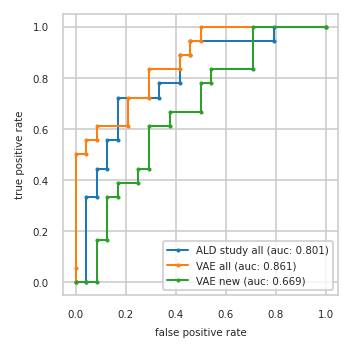

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.333   0.000 0.500   0.083 0.000
3          0.083 0.333   0.042 0.500   0.083 0.167
4          0.083 0.444   0.042 0.556   0.125 0.167
5          0.125 0.444   0.083 0.556   0.125 0.333
6          0.125 0.556   0.083 0.611   0.167 0.333
7          0.167 0.556   0.208 0.611   0.167 0.389
8          0.167 0.722   0.208 0.722   0.250 0.389
9          0.333 0.722   0.292 0.722   0.250 0.444
10         0.333 0.778   0.292 0.833   0.292 0.444
11         0.417 0.778   0.417 0.833   0.292 0.611
12         0.417 0.889   0.417 0.889   0.375 0.611
13         0.458 0.889   0.458 0.889   0.375 0.667
14         0.458 0.944   0.458 0.944   0.500 0.667
15         0.792 0.944   0.500 0.944   0.500 0.778
16         0.792 1.000   0.500 1.000   0.542 0.778
17         1.000 1.000   1.000 1.000   0.542 0.833
18           NaN   NaN     NaN   NaN   0.708 0.833
19           NaN   NaN     NaN   NaN   0.708 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,P08670,J3KSJ8;Q9UD71;Q9UD71-2
2,D6RGG3;Q99715,H0YMB1;Q96TC7;Q96TC7-2,P51688
3,Q99983,Q9Y2T3;Q9Y2T3-3,P31321
4,P14174,P04075,A0A075B7B8
5,P10636-2;P10636-6,P51688,Q96GD0
6,P61981,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,P18428,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,Q9Y2T3;Q9Y2T3-3,P63104,Q9NUQ9


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


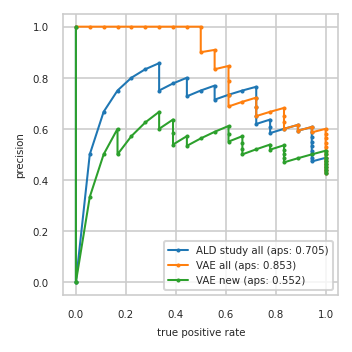

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.593 0.889     0.593 0.889     0.519 0.778
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.600 0.833     0.600 0.833     0.520 0.722
18         0.583 0.778     0.625 0.833     0.500 0.667
19         0.609 0.778     0.652 0.833     0.522 0.667
20         0.636 0.778     0.682 0.833     0.545 0.667
21         0.619 0.722     0.667 0.778     0.571 0.667
22         0.650 0.722     0.650 0.722     0.550 0.611
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.722 0.722     0.722 0.722     0.611 0.611
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.733 0.611     0.733 0.611     0.533 0.444
28         0.714 0.556     0.786 0.611     0.571 0.444
29         0.769 0.556     0.846 0.611     0.538 0.389
30         0.750 0.500     0.833 0.556     0.583 0.389
31         0.727 0.444     0.909 0.556     0.636 0.389
32         0.800 0.444     0.900 0.500     0.600 0.333
33         0.778 0.389     1.000 0.500     0.667 0.333
34         0.750 0.333     1.000 0.444     0.625 0.278
35         0.857 0.333     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


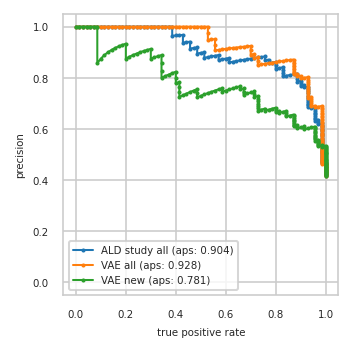

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


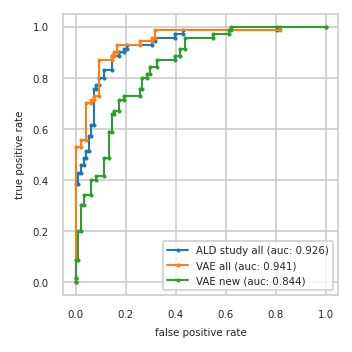

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}